# Assignment 11 - Updated Version

*by Angelica Hjelm Gardner, Muhammad Farooq, and Omid Golshan Tafti.*

This report is an updated version we worked on according to received feedback.
In this updated version, we've made the following changes:

- Used only one approach for labeling the data and stick with it for the entire assignment;
- Replaced multi-class classification with binary classification so this time, we have defined 2 x 2 models: (1) Start frames Kinect, (2) Start frames PoseNet, (3) Stop/End frames Kinect, and (4) Stop/End frames PoseNet.
- Added additional data augmentation and describe how these are computed in the Notebook;
- Test variants of hidden layers, activation functions, initialization, batch-size, and optimizers;
- Separate 10% of all data for validation (holdout set) and evaluated models on that;
- Added all executable code to the Notebook;
- Included the following metrics: Precision, Recall, F1, Accuracy, and Confusion Matrix.
- Added compute_class_weight from scikit-learn.utils to estimate the class weight;
- Report on the effects of doing different imbalanced dataset techniques; and
- Evaluated the usefulness of the selected classifier(s) in the application context.

## Introduction (*this part is kept intact from the first submission*)

This week, we've performed ML experimentations to recognize the start and stop of exercise sequences from recorded deep squat videos. We trained ML models to distinguish start and stop positions, so that the videos can be cut to only assess sequences showing the actual exercise.

In this report, we go through the deep learning steps: from the preparation of data to defining and experimenting with DL models, as well as evaluating model performance.

At the end of the report, an update about our workflow setup is included to show that we have received and acknowledged feedback about this area from our latest assignment.

<br/>

----

## Table of Contents

1. **Data Preprocessing**

    1.1 Marking Start and Stop

    1.2 Inspect Class Imbalance

2. **Define a Suitable Deep Learning Model**

    2.1 Problem A (Kinect)

    - 2.1.1 Kinect Cut Start model

    - 2.1.2 Kinect Cut Stop model

    2.2 Problem B (PoseNet)

    - 2.2.1 PoseNet Cut Start model

    - 2.2.2 PoseNet Cut Stop model

3. **Conclusions and The Champion Model**

4. **Jira Updates**

----

# 1. Data Preprocessing

We have used three different datasets in this assignment, so for clarification, we'll briefly go through them and what we will be calling them for the rest of the report:

- PoseNet video output (uncut). This is the data we receive when feeding a video input into our PoseNet model and it gives us joint positions in 2D (X, Y) as output. All frames are preserved so each file contains positions from the start of the video until its end. 
We're referring to this as the **posenet_dataset**. 

- Kinect video output (uncut). We received this dataset from stakeholders and it contains joint positions from a Kinect device in 3D (X, Y, Z). All frames are preserved so each file contains positions from the start of the video until its end.
We're referring to this as the **kinect_uncut_dataset**.

- Kinect video output (cut). This is also a dataset we received from stakeholders and each file contains the same Kinect output as the dataset described above, but this time, frames at the start and at the end of the exercise has been removed so the file only contains frames with positions for the actual movement.
We're referring to this as the **kinect_cut_dataset**.

## 1.1 Marking Start and Stop

In the original report, we used four different methods for marking start and stop frames. We were told that sticking to one approach would be better and less confusing, so we chose the method were we approach the solution as a binary classification and therefore, we need a "Start" column where each frame is marked with 0 (Not a start frame) or 1 (Start frame). We also need the same sitatuation with an "End" column.

We will read the CSV files from the datasets mentioned above, find the start and end frame numbers from the cut Kinect dataset and match those frame numbers in Kinect uncut dataset as well as PoseNet dataset. Finally, we'll save this dataset to use for our model training.

The Notebook we used for processing the data can be found here [mark_start_and_end.ipynb](https://github.com/digitacs/4dv652-ml/blob/main/notebooks/assignment11/2%20mark_start_and_end.ipynb) and the processed and saved CSV files were uploaded to our repository and can be found here: [marked_start_end](https://github.com/digitacs/4dv652-ml/tree/main/datasets/marked_start_end).

In [1]:
import numpy as np
import pandas as pd

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

mark_before =  2
mark_after =  2
save_kinect_as_well = True

cut_dataset_path = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/kinect_good_preprocessed/"
uncut_dataset_path = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/kinect_good_preprocessed_not_cut/"
posetnet_dataset_path = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/posenet-uncut/old_posenet-python/"

In [2]:
def mark_start_and_stop( file_name ):
    print('Marking "{}"'.format(file_name), end='')
    
    try:
        # read diffrent version of the given file name
        cut_data = pd.read_csv(cut_dataset_path+'{}_kinect.csv'.format( file_name ))
        uncut_data = pd.read_csv(uncut_dataset_path+'{}_kinect.csv'.format( file_name ))
        posenet_data = pd.read_csv(posetnet_dataset_path+'{}.csv'.format( file_name ))

        # find the start and end frame number from cutted dataset
        start = cut_data.iloc[0]['FrameNo']
        end = cut_data.iloc[len(cut_data)-1]['FrameNo']

        # find the start and end frame number from uncutted dataset
        start_uncut = uncut_data.iloc[0]['FrameNo']
        end_uncut = uncut_data.iloc[len(uncut_data)-1]['FrameNo']

        # in some cases even uncuted version won't start from zero
        # to be sure we will go for the maximum/maximum :D
        start = np.maximum(start, start_uncut)
        end = np.minimum(end, end_uncut)

        print(' | start:{} - end:{}'.format(start,end), end='')

        # add a new columns for the start/end classes
        posenet_data['start'] = None
        posenet_data['end'] = None
        uncut_data['start'] = None
        uncut_data['end'] = None

        # mark the coresponding frame and it's surrounds in posenet dataset
        posenet_data.loc[
            ((posenet_data['FrameNo'] <= start+mark_after)),
            'start'
        ] = '1'
        
        posenet_data.loc[
            ((posenet_data['FrameNo'] > start+mark_after)),
            'start'
        ] = '0'

        posenet_data.loc[
            ((posenet_data['FrameNo'] < end-mark_before)),
            'end'
        ] = '0'
        
        posenet_data.loc[
            ((posenet_data['FrameNo'] >= end-mark_before)),
            'end'
        ] = '1'


        # mark the coresponding frame and it's surrounds in uncut kinect dataset
        uncut_data.loc[
            ((uncut_data['FrameNo'] <= start+mark_after)),
            'start'
        ] = '1'
        
        uncut_data.loc[
            ((uncut_data['FrameNo'] > start+mark_after)),
            'start'
        ] = '0'

        uncut_data.loc[
            ((uncut_data['FrameNo'] < end-mark_before)),
            'end'
        ] = '0'
        
        uncut_data.loc[
            ((uncut_data['FrameNo'] >= end-mark_before)),
            'end'
        ] = '1'

        print(' Done!')
        
        return posenet_data, uncut_data
    
    except IOError as e:
        print(e)
        return None,None

Process and save the A-series files.

In [3]:
for a in range(1,160):
    # marke start and end frames
    posenet, uncut_kinect = mark_start_and_stop( 'A{}'.format(a) )
    
    # jump to next file if current one is unavailable
    if(posenet is None):
        continue
    
    # save posenet dataset to a csv file
    posenet.to_csv('A{}.csv'.format(a),index=False)
    
    if save_kinect_as_well:
        # save uncut kinect dataset to a csv file
        uncut_kinect.to_csv('A{}_kinect.csv'.format(a),index=False)

Marking "A1" | start:68.0 - end:179.0 Done!
Marking "A2" | start:70.0 - end:223.0 Done!
Marking "A3" | start:55.0 - end:182.0 Done!
Marking "A4" | start:56.0 - end:219.0 Done!
Marking "A5" | start:55.0 - end:168.0 Done!
Marking "A6" | start:30.0 - end:172.0 Done!
Marking "A7" | start:46.0 - end:187.0 Done!
Marking "A8" | start:51.0 - end:194.0 Done!
Marking "A9" | start:41.0 - end:174.0 Done!
Marking "A10" | start:42.0 - end:202.0 Done!
Marking "A11" | start:24.0 - end:241.0 Done!
Marking "A12" | start:13.0 - end:179.0 Done!
Marking "A13" | start:14.0 - end:178.0 Done!
Marking "A14" | start:0.0 - end:162.0 Done!
Marking "A15" | start:12.0 - end:134.0 Done!
Marking "A16" | start:30.0 - end:150.0 Done!
Marking "A17" | start:21.0 - end:142.0 Done!
Marking "A18" | start:54.0 - end:167.0 Done!
Marking "A19" | start:29.0 - end:148.0 Done!
Marking "A20" | start:24.0 - end:127.0 Done!
Marking "A21" | start:24.0 - end:142.0 Done!
Marking "A22" | start:38.0 - end:135.0 Done!
Marking "A23" | star

Process and save the B-series files.

In [4]:
for b in range(1,23):
    # marke start and end frames
    posenet,uncut_kinect = mark_start_and_stop( 'B{}'.format(b) )
    
    # jump to next file if current one is unavailable
    if(posenet is None):
        continue
        
    # save posenet dataset to a csv file
    posenet.to_csv('B{}.csv'.format(b),index=False)
    
    if save_kinect_as_well:
        # save uncut kinect dataset to a csv file
        uncut_kinect.to_csv('B{}_kinect.csv'.format(b),index=False)

Marking "B1" | start:69.0 - end:121.0 Done!
Marking "B2" | start:29.0 - end:117.0 Done!
Marking "B3" | start:23.0 - end:109.0 Done!
Marking "B4" | start:0.0 - end:98.0 Done!
Marking "B5" | start:41.0 - end:139.0 Done!
Marking "B6" | start:157.0 - end:262.0 Done!
Marking "B7" | start:123.0 - end:218.0 Done!
Marking "B8" | start:108.0 - end:195.0 Done!
Marking "B9" | start:96.0 - end:183.0 Done!
Marking "B10" | start:108.0 - end:193.0 Done!
Marking "B11" | start:70.0 - end:190.0 Done!
Marking "B12" | start:106.0 - end:189.0 Done!
Marking "B13" | start:153.0 - end:239.0 Done!
Marking "B14" | start:113.0 - end:204.0 Done!
Marking "B15" | start:111.0 - end:203.0 Done!
Marking "B16" | start:124.0 - end:207.0 Done!
Marking "B17" | start:110.0 - end:207.0 Done!
Marking "B18" | start:108.0 - end:196.0 Done!
Marking "B19" | start:101.0 - end:195.0 Done!
Marking "B20" | start:98.0 - end:196.0 Done!
Marking "B21" | start:98.0 - end:200.0 Done!
Marking "B22" | start:90.0 - end:173.0 Done!


## 1.2 Inspect Class Imbalance

Finally, we want to inspect the class imbalance in the dataset we just saved by loading the files and group them according to start and stop frames.

This class imbalance check shows us the small amount of start and stop frames, from which we can understand that we will need to implement some imbalanced techniques during model training.

In [5]:
dataset = None

for i in range(1,160):
  try:
    data = pd.read_csv('A{}_kinect.csv'.format(i), index_col=0)
    
    if dataset is None:
      dataset = data
    else:
      dataset = pd.concat((dataset, data),ignore_index=True)
  except:
    print('Could not load file A{}_kinect.csv'.format(i))

for i in range(1,23):
  try:
    data = pd.read_csv('B{}_kinect.csv'.format(i), index_col=0)
    dataset = pd.concat((dataset, data),ignore_index=True)
  except:
    print('Could not load file B{}_kinect.csv'.format(i))

print('\n', dataset.shape)
print(dataset['start'].unique())
print(dataset['end'].unique())

Could not load file A60_kinect.csv
Could not load file A107_kinect.csv

 (37782, 41)
[1 0]
[0 1]


How many start frames do we have?

In [6]:
train_gc = dataset.groupby(['start']).size()
print(
    'Total: {}\n\nStart: {} ({:.2f}% of total)\n'
    .format(
      len(dataset), 
      train_gc[1],
      train_gc[1] / len(dataset),
    )
  )

Total: 37782

Start: 7814 (0.21% of total)



How many stop frames do we have?

In [7]:
train_gc = dataset.groupby(['end']).size()
print(
    'Total: {}\n\nEnd: {} ({:.2f}% of total)\n'
    .format(
      len(dataset), 
      train_gc[1],
      train_gc[1] / len(dataset),
    )
  )

Total: 37782

End: 7037 (0.19% of total)



# 2. Define a Suitable Deep Learning Model

We approached solving this problem as a multi-class solution in the first submission, but after experimenting with binary classification instead - we found that it was much easier to reach a better performance for the models, so we switched to that approach.

In this section, we present:

- Start model for Kinect (problem A)
- Stop model for Kinect (problem A)
- Start model for PoseNet (problem B)
- Stop model for PoseNet (problem B)

We will also try each model in three different scenarios:
- Baseline model 
- Using the imbalance technique of class weights
- Using the imbalance technique of oversamling

## 2.1 Problem A (Kinect)

In this section, we'll work with the Kinect Start and Stop models.

### 2.1.1 Kinect Cut Start model

We have worked in [cut_start_kinect.ipynb](https://github.com/digitacs/4dv652-ml/blob/main/notebooks/assignment13/cut_start_kinect.ipynb) when experimenting with 11 versions of this model, and the experiment results are saved in [MLflow dashboard](http://35.228.45.76:5000/#/compare-runs?runs=[%2214b3d62fe0ac449d98a19e883e57133c%22,%226f3634d228d643938f7a6d41ffd8f46e%22,%221caa916678fd4b2eab0928c70a4ec451%22,%227403b22119ba465c8c033f93539a2d48%22,%22fbba435e3df043029f755fbfd6cf20c3%22,%22e75edd96d07e4bd2a4555786965a35c2%22,%22c92ade4517844c7182ca5bf24a1c7e17%22,%22140fe03e83f94946b953f02d2e37cacd%22,%225bc55dc1d2534a259459bc711d10cac9%22,%223fdb4eee8e7c47aca493d7ac0c77c5e1%22,%22a35c4332c8d94eba9a9d082d265617c6%22]&experiment=0) for easy comparison.

Let's start by loading the dataset.

In [8]:
data_path = 'https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/marked_start_end/'

df = None

In [9]:
# Loading A-files
for i in range(1, 160):
  try:
    dataset = pd.read_csv(data_path + 'A{}_kinect.csv'.format(i))
    dataset.drop(columns=['FrameNo'], inplace=True)

    if df is None:
      df = dataset
    else:
      df = pd.concat((df, dataset), ignore_index=True)

  except IOError as e:
    print("Error in reading files: 'A{}_kinect.csv'.format(i),", e)

# Loading B-files
for i in range(1, 23):
  try:
    dataset = pd.read_csv(data_path + 'B{}_kinect.csv'.format(i))
    dataset.drop(columns=['FrameNo'], inplace=True)

    if df is None:
      df = dataset
    else:
      df = pd.concat((df, dataset), ignore_index=True)

  except IOError as e:
    print("Error in reading file: 'B{}_kinect.csv'.format(i),", e)

print(df.shape)

Error in reading files: 'A{}_kinect.csv'.format(i), HTTP Error 404: Not Found
Error in reading files: 'A{}_kinect.csv'.format(i), HTTP Error 404: Not Found
(37782, 41)


We will use some data augmentation. In the previous submission of this report, we only mirrored the data on the X-axis using addition. But now we have updated that method and also added another augmentation method which will stretch by the percentage of choice.

In [10]:
def mirror(data, axis, append=False):
    try:
        
        if axis == 'a':
            target_labels = [col for col in data.columns]
        else:
            axis = "_" + axis
            target_labels = [col for col in data.columns if axis in col]

        aug_data_mirror = data.copy()

        for t in target_labels:
            temp = -aug_data_mirror[t]
            aug_data_mirror = aug_data_mirror.assign(**{t: temp.values})

        if append:
            return data.append(aug_data_mirror,ignore_index=True)

        return aug_data_mirror
    
    except IOError as e:
        print(e)
        return None

In [11]:
def augMultiplier(data, multiplier, append=False):
    
    try:
        aug_data_offset = data.copy()
        aug_data_offset *= multiplier
        if append:
            return data.append(aug_data_offset,ignore_index=True)
        
        return aug_data_offset
    
    except IOError as e:
        print(e)
        return None

In [12]:
print('Initial shape:', df.shape, '\n')

df = mirror(df,'x', append=True)
print('Shape after mirror augmentation:', df.shape)

Initial shape: (37782, 41) 

Shape after mirror augmentation: (75564, 41)


In [13]:
df = augMultiplier(df, 1.5, append=True)
print('Shape after stretching:', df.shape)

Shape after stretching: (151128, 41)


One of the class imbalance techniques that we will be using is Oversampling. We won't use undersampling because we don't want to reduce the dataset. 

Oversampling is a type of data augmentation for the minority class (in our case: the start/stop frames) where we replicate that minority class until we get the class balance we're looking for. <br />
We will be using the SMOTE technique which works by creating synthetic examples of the minority class because it forces the decision region of the minority class to become more general.

So, when using oversampling to train the model, we will use the resampled_X and resampled_y sets, but when setting class weights, we will use the normal X and y sets.

In [14]:
X = df.drop(columns=['start', 'end'])
y = df['start']
y = y.astype(int)

from sklearn.utils import shuffle

X, y = shuffle(X, y)

In [15]:
from imblearn.over_sampling import SMOTE

random_state = 42
np.random.seed(random_state)

sm = SMOTE(random_state=random_state)
resampled_X, resampled_y = sm.fit_resample(X, y)

print(resampled_X.shape)
print(resampled_y.shape)

(239744, 39)
(239744,)


Next, we'll split the dataset into train, validation, and test sets:

- The validation set is used during model fitting to evaluate the loss and other evaluation metrics.
- The test set is unused during the training phase and is used at the end to evaluate how well the model generalizes to new data (i.e. a holdout set). This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

We also normalize the input features using the sklearn StandardScaler. StandardScaler is only fit using X_train. As we want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.

The ratio between the splits are 10% (0.1) for validation and then the rest 90% (0.9) will be split into 20:80 ratio where 20% is for test set and the remaining 80% for training.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [17]:
resampled_X_train, resampled_X_test, resampled_y_train, resampled_y_test = train_test_split(resampled_X, resampled_y, test_size=0.1, random_state=random_state)
resampled_X_train, resampled_X_val, resampled_y_train, resampled_y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

resampled_scaler = StandardScaler()
resampled_X_train = resampled_scaler.fit_transform(resampled_X_train)

resampled_X_val = resampled_scaler.transform(resampled_X_val)
resampled_X_test = resampled_scaler.transform(resampled_X_test)

print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape, '\n')

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (108812,)
Validation labels shape: (27203,)
Test labels shape: (15113,) 

Training features shape: (108812, 39)
Validation features shape: (27203, 39)
Test features shape: (15113, 39)


The data preparation steps are finished and we'll start training the DL model. We have been working with Dense layers for this model.

Let's start by defining the experimentation configurations. We will use early stopping during training, and common binary classification metrics for evaluation.

In [19]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC

early_stopping = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

EPOCHS = 500
BATCH_SIZE = 2000

METRICS = [
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

# Input and output size
input_dim = X_train.shape[1]
output_size = 1

The **create_model()** function will create and return the DL model to us.
We're using a function for this purpose because we will be creating several models so it's convenient to not repeat the model architecture and only supply different parameter values.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout

def create_model(units, activation, kernel_initializer, output_activation, optimizer):
    model = Sequential([
        InputLayer(input_shape=(input_dim))
    ])

    model.add(Dense(units=units, activation=activation, kernel_initializer=kernel_initializer))
    model.add(Dropout(0.5))
    if not output_activation:
      model.add(Dense(units=output_size))
    else:
      model.add(Dense(units=output_size, activation=output_activation))

    model.compile(
      optimizer=optimizer,
      loss='binary_crossentropy',
      metrics=METRICS)

    print(model.summary())

    return model

When comparing the parameter value experimentations in [MLflow dashboard](http://35.228.45.76:5000/#/compare-runs?runs=%5B%2214b3d62fe0ac449d98a19e883e57133c%22,%226f3634d228d643938f7a6d41ffd8f46e%22,%221caa916678fd4b2eab0928c70a4ec451%22,%227403b22119ba465c8c033f93539a2d48%22,%22fbba435e3df043029f755fbfd6cf20c3%22,%22e75edd96d07e4bd2a4555786965a35c2%22,%22c92ade4517844c7182ca5bf24a1c7e17%22,%22140fe03e83f94946b953f02d2e37cacd%22,%225bc55dc1d2534a259459bc711d10cac9%22,%223fdb4eee8e7c47aca493d7ac0c77c5e1%22,%22a35c4332c8d94eba9a9d082d265617c6%22%5D&experiment=0) we could draw a few conclusions:

- ReLU gave the highest accuracy as activation function for hidden layers;
- Larger batch sizes, such as 2000, increased the accuracy. Perhaps because the dataset is imbalanced so it makes sure some examples of each class in each batch?
- Lower learning rate for higher batch sizes worked well, but larger learning rates were better for smaller batch sizes;
- Adam was the best performing optimizer; and
- A greater value for units in the Dense layers (such as 64) made the models learn better.

To easily compare the imbalanced dataset techniques with each other and the baseline, we will stick to the same (and best performing) parameter values 

We will start by looking at the Baseline model version. Let us give it some parameter values and start the training phase.

In [21]:
baseline_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

baseline_history = baseline_model.fit(
            x=X_train, 
            y=y_train, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2560      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
55/55 [==============================] - 3s 25ms/step - loss: 0.4910 - accuracy: 0.7514 - precision: 0.3758 - recall: 0.3047 - auc: 0.7179 - prc: 0.3392 - val_loss: 0.3645 - val_accuracy: 0.8302 - val_precision: 0.6933 - val_recall: 0.3190 - val_auc: 0.8502 - val_prc: 0.5867
Epoch 2/500
55/55 [==============================] - 1s 12ms/step - loss: 0.3848 - accuracy

Let's take a look at the training history by producing plots of the baseline model's accuracy and loss on the training and validation set. These are useful to check for overfitting.

The learning history seems to be not great but quite ok and normal, nothing that stands out as weird to us.

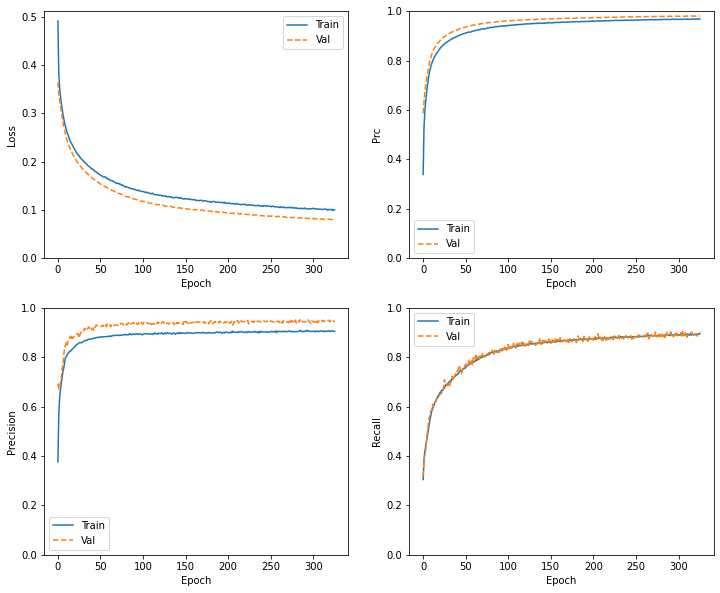

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_history(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_history(baseline_history)

The role of bias in a model is to learn a preference for the most frequent class and by removing the bias from the model, we will force it not to use this strategy. So next, we're going to train another model with class weights to see how this imbalanced dataset technique will affect the model performance.

First, we need to calculate the class weights and then use them when computing the loss function so that when can make the underrepresented class more prominent and make sure the model learns more about it.

In [23]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

print('Weight for start frames:', class_weights[1])
print('Weight for normal frames:', class_weights[0])

Weight for start frames: 2.416433488785254
Weight for normal frames: 0.6304506529775079


In [24]:
weighted_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

weighted_history = weighted_model.fit(
            x=X_train, 
            y=y_train, 
            class_weight=class_weight_dict, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                2560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
55/55 [==============================] - 3s 25ms/step - loss: 0.7318 - accuracy: 0.6642 - precision: 0.3422 - recall: 0.6759 - auc: 0.7498 - prc: 0.4737 - val_loss: 0.5230 - val_accuracy: 0.6878 - val_precision: 0.3920 - val_re

By plotting the history, it seems like the weighted model is suffering from a bad performance with precision with also negatively affects PRC.

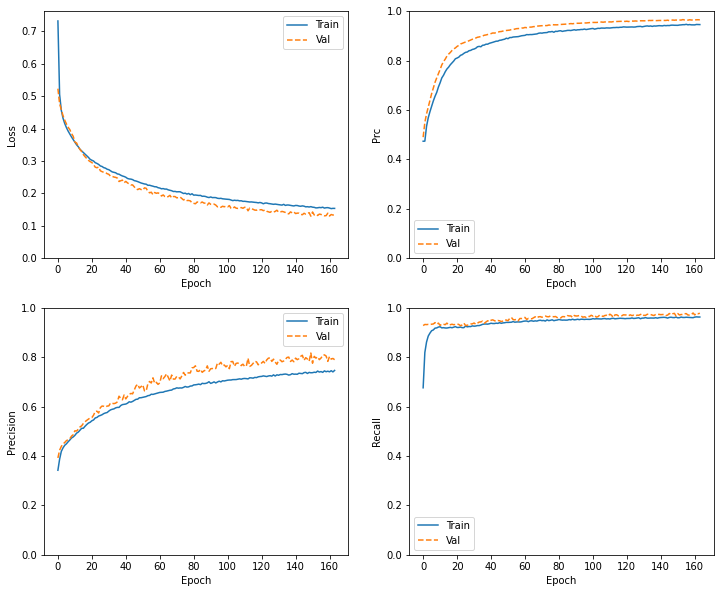

In [26]:
plot_history(weighted_history)

Lastly, we'll also train another model with the same architecture using oversampling as the imbalanced dataset technique. 

For this model, the oversampled dataset will be used.

In [27]:
oversampled_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

oversampled_history = oversampled_model.fit(
            x=resampled_X_train, 
            y=resampled_y_train, 
            validation_data=(resampled_X_val, resampled_y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                2560      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
44/44 [==============================] - 3s 27ms/step - loss: 0.7675 - accuracy: 0.6832 - precision: 0.3274 - recall: 0.5037 - auc: 0.7080 - prc: 0.4234 - val_loss: 0.4179 - val_accuracy: 0.7950 - val_precision: 0.5310 - val_recall: 0.0647 - val_auc: 0.7836 - val_prc: 0.4204
Epoch 2/500
44/44 [==============================] - 1s 13ms/step - loss: 0.4643 - accura

Training history of the oversampled model looks quite ok but recall learning seems to be a bit on the lower edge.

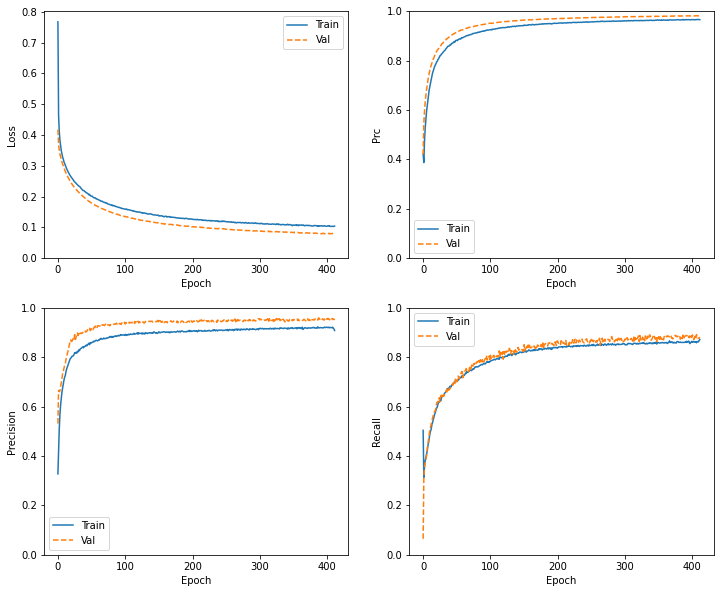

In [28]:
plot_history(oversampled_history)

Finally, let's compare information and performance of the Kinect Cut Start models by defining functions for plotting the confusion matrix and ROC. 
We'll also print the evaluation metrics.

In [29]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

In [30]:
from sklearn.metrics import roc_curve

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

--- BASELINE MODEL ---
loss :  0.0767810121178627
accuracy :  0.9706875085830688
precision :  0.9472277760505676
recall :  0.9086831212043762
auc :  0.9952743053436279
prc :  0.9835292100906372



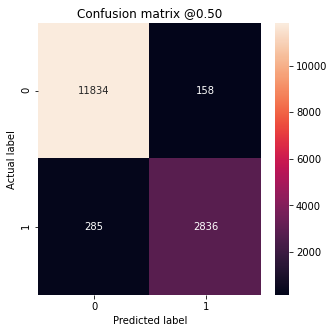


--- MODEL WITH CLASS WEIGHTS ---
loss :  0.12972378730773926
accuracy :  0.9452788829803467
precision :  0.801207959651947
recall :  0.9775713086128235
auc :  0.9917303323745728
prc :  0.9686145186424255



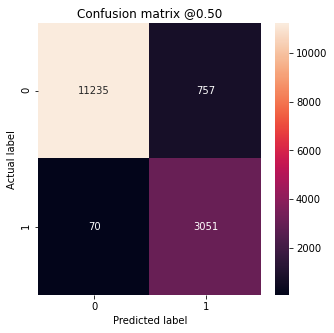


--- OVERSAMPLED MODEL ---
loss :  0.12892863154411316
accuracy :  0.9396037459373474
precision :  0.9874735474586487
recall :  0.890966534614563
auc :  0.995134711265564
prc :  0.9951138496398926



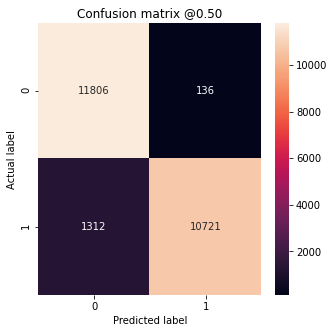

In [31]:
import seaborn as sns

baseline_predictions = baseline_model.predict(X_test)
weighted_predictions = weighted_model.predict(X_test)
oversampled_predictions = oversampled_model.predict(resampled_X_test)

baseline_results = baseline_model.evaluate(X_test, 
                                          y_test,
                                          batch_size=BATCH_SIZE, 
                                          verbose=0)
weighted_results = weighted_model.evaluate(X_test, 
                                              y_test,
                                              batch_size=BATCH_SIZE, 
                                              verbose=0)
oversampled_results = oversampled_model.evaluate(resampled_X_test, 
                                                resampled_y_test,
                                                batch_size=BATCH_SIZE, 
                                                verbose=0)

print('--- BASELINE MODEL ---')
for name, value in zip(baseline_model.metrics_names, baseline_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, baseline_predictions) 
print('')

print('--- MODEL WITH CLASS WEIGHTS ---')
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, weighted_predictions) 
print('')

print('--- OVERSAMPLED MODEL ---')
for name, value in zip(oversampled_model.metrics_names, oversampled_results):
  print(name, ': ', value)
print('')
plot_cm(resampled_y_test, oversampled_predictions) 

From the results of metrics values, confusion matrices, and ROC curves, we can draw the following conclusions:

- The baseline model had the highest accuracy and it also showed the best ROC performance where its blue line covered the most surface below the curve. However, it seems to be performing better on the training set than the test set so that might be a sign of overfitting?
- As for the imbalanced dataset techniques, they seemed to have different affects on the models. For class weight, the model has a lot of false positives (which gives a lower precision) which means it incorrectly predictions normal frames to be start frames as well. 
- For the oversampled model, we have the opposite situation with a lower recall value and more false negatives which means that it misses start frames.

For now, the baseline model without imbalanced techniques seems to be the best choice.
But we will look at the Kinect stop frames next.

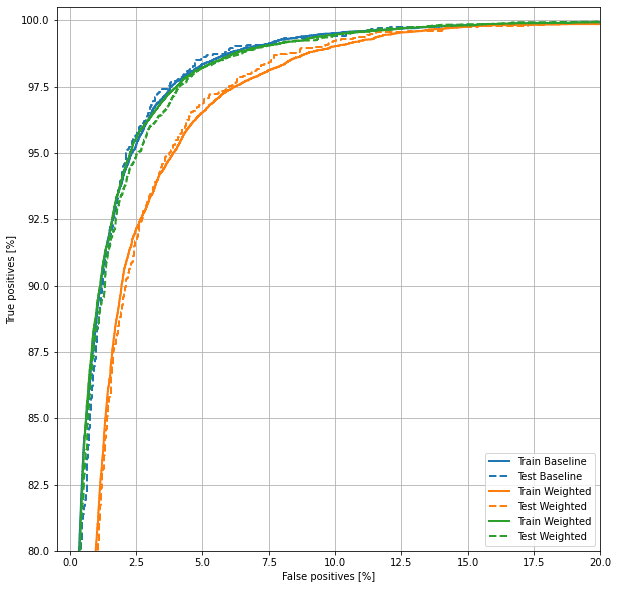

In [32]:
train_baseline_predictions = baseline_model.predict(X_train)
train_weighted_predictions = weighted_model.predict(X_train)
train_oversampled_predictions = oversampled_model.predict(resampled_X_train)

plot_roc("Train Baseline", y_train, train_baseline_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_predictions, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_weighted_predictions, color=colors[1])
plot_roc("Test Weighted", y_test, weighted_predictions, color=colors[1], linestyle='--')

plot_roc("Train Weighted", resampled_y_train, train_oversampled_predictions, color=colors[2])
plot_roc("Test Weighted", resampled_y_test, oversampled_predictions, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

### 2.1.2 Kinect Cut Stop model

We have worked in [cut_stop_kinect.ipynb](https://github.com/digitacs/4dv652-ml/blob/main/notebooks/assignment13/cut_stop_kinect.ipynb) when experimenting with 3 versions of this model, and the experiment results are saved in [MLflow dashboard](http://35.228.45.76:5000/#/compare-runs?runs=[%22550767846e1441389ca2c312d5b73355%22,%22ef3c445b97af4119bcd587a6e0bd4fcd%22,%229528dd609c584bea9f6d98346291287a%22]&experiment=0) for easy comparison. We did not have to experiment as much with this model as it worked very similar to cutting start frames from the same Kinect data.

We do not have to load the dataset again, but we do need to recreate the X and y sets because before, we dropped the "end" column and kept the "start" column, but now we have to do the reversed situation.

In [33]:
X = df.drop(columns=['end', 'start'])
y = df['end']
y = y.astype(int)

X, y = shuffle(X, y)

In [34]:
random_state = 42
np.random.seed(random_state)

sm = SMOTE(random_state=random_state)
resampled_X, resampled_y = sm.fit_resample(X, y)

print(resampled_X.shape)
print(resampled_y.shape)

(245960, 39)
(245960,)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [36]:
resampled_X_train, resampled_X_test, resampled_y_train, resampled_y_test = train_test_split(resampled_X, resampled_y, test_size=0.1, random_state=random_state)
resampled_X_train, resampled_X_val, resampled_y_train, resampled_y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

resampled_scaler = StandardScaler()
resampled_X_train = resampled_scaler.fit_transform(resampled_X_train)

resampled_X_val = resampled_scaler.transform(resampled_X_val)
resampled_X_test = resampled_scaler.transform(resampled_X_test)

print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape, '\n')

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (108812,)
Validation labels shape: (27203,)
Test labels shape: (15113,) 

Training features shape: (108812, 39)
Validation features shape: (27203, 39)
Test features shape: (15113, 39)


And then we begin the experimentation with the baseline model, followed by the weighted model, and lastly the oversampled model - all for cutting Kinect stop frames.

And we see from its learning history that the recall value seems to be low.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                2560      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
55/55 [==============================] - 3s 28ms/step - loss: 0.4092 - accuracy: 0.8504 - precision: 0.7820 - recall: 0.5352 - auc: 0.8500 - prc: 0.7478 - val_loss: 0.3237 - val_accuracy: 0.8692 - val_precision: 0.9369 - val_recall: 0.3132 - val_auc: 0.8339 - val_prc: 0.6222
Epoch 2/500
55/55 [==============================] - 1s 13ms/step - loss: 0.3452 - accura

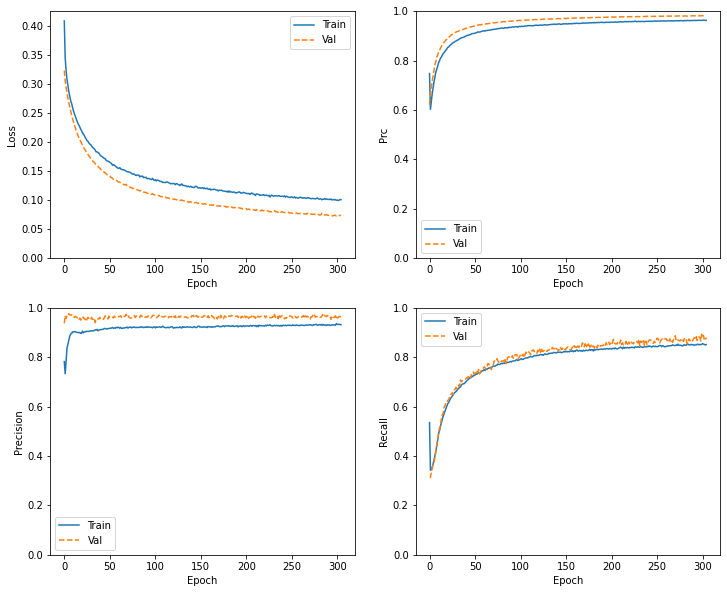

In [38]:
baseline_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

baseline_history = baseline_model.fit(
            x=X_train, 
            y=y_train, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(baseline_history)

Moving on to the weigted model.<br />
We can see that we have similar class weights for stop frames as we had for start frames.

In [39]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

print('Weight for normal frames:', class_weights[0])
print('Weight for stop frames:', class_weights[1])

Weight for normal frames: 0.6148543272382072
Weight for stop frames: 2.6766702745252386


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                2560      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
55/55 [==============================] - 3s 24ms/step - loss: 0.7557 - accuracy: 0.6771 - precision: 0.3209 - recall: 0.6559 - auc: 0.7547 - prc: 0.5447 - val_loss: 0.5038 - val_accuracy: 0.7128 - val_precision: 0.3675 - val_recall: 0.7696 - val_auc: 0.8377 - val_prc: 0.6282
Epoch 2/500
55/55 [==============================] - 1s 14ms/step - loss: 0.5145 - accura

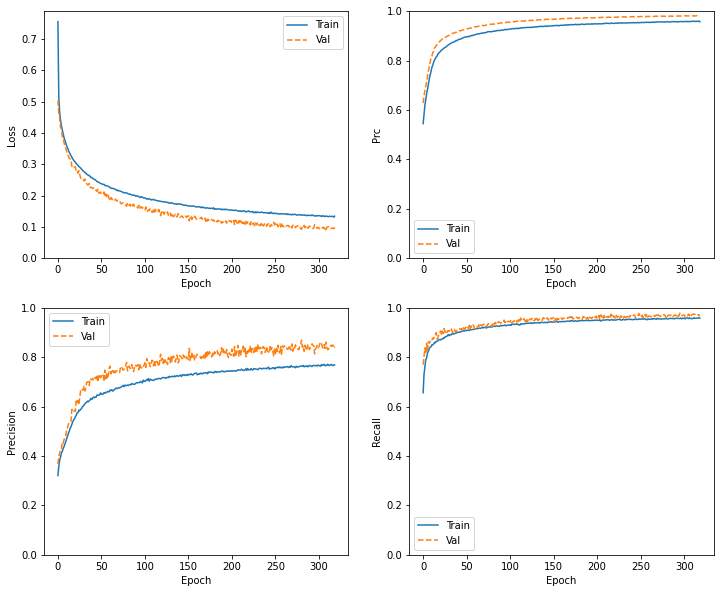

In [40]:
weighted_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

weighted_history = weighted_model.fit(
            x=X_train, 
            y=y_train, 
            class_weight=class_weight_dict, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(weighted_history)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                2560      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
44/44 [==============================] - 3s 29ms/step - loss: 0.6525 - accuracy: 0.7600 - precision: 0.3806 - recall: 0.4593 - auc: 0.7242 - prc: 0.5074 - val_loss: 0.3727 - val_accuracy: 0.8615 - val_precision: 0.9489 - val_recall: 0.2738 - val_auc: 0.7554 - val_prc: 0.5513
Epoch 2/500
44/44 [==============================] - 1s 12ms/step - loss: 0.4131 - accura

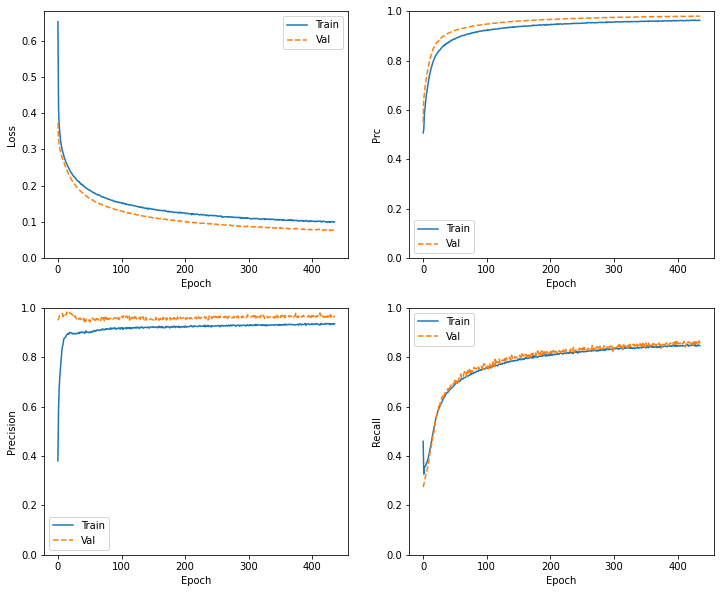

In [41]:
oversampled_model = create_model(64, 'relu', 'he_uniform', 'sigmoid', 'adam')

oversampled_history = oversampled_model.fit(
            x=resampled_X_train, 
            y=resampled_y_train, 
            validation_data=(resampled_X_val, resampled_y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

plot_history(oversampled_history)

And looking at the model performances for cutting stop frames.

--- BASELINE MODEL ---
loss :  0.0741536021232605
accuracy :  0.9714153409004211
precision :  0.9731892943382263
recall :  0.8695030212402344
auc :  0.9938886761665344
prc :  0.9812223315238953



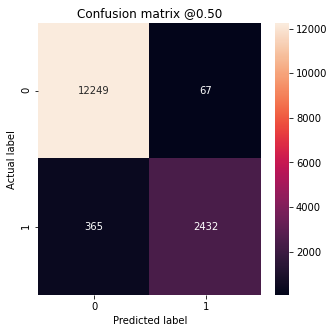


--- MODEL WITH CLASS WEIGHTS ---
loss :  0.09049420803785324
accuracy :  0.9640706777572632
precision :  0.8591459393501282
recall :  0.9638898968696594
auc :  0.9952149987220764
prc :  0.9818297028541565



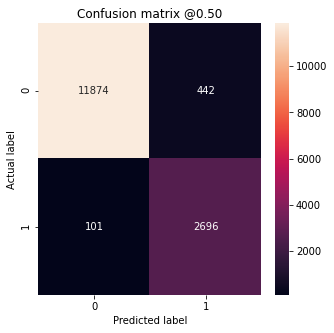


--- OVERSAMPLED MODEL ---
loss :  0.1424511969089508
accuracy :  0.9308830499649048
precision :  0.9924207329750061
recall :  0.869040846824646
auc :  0.9948577284812927
prc :  0.9951329827308655



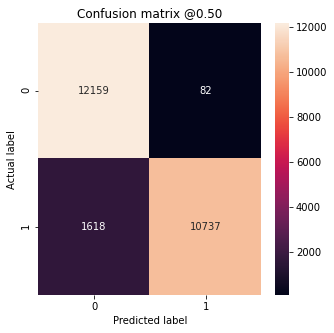

In [42]:
baseline_predictions = baseline_model.predict(X_test)
weighted_predictions = weighted_model.predict(X_test)
oversampled_predictions = oversampled_model.predict(resampled_X_test)

baseline_results = baseline_model.evaluate(X_test, 
                                          y_test,
                                          batch_size=BATCH_SIZE, 
                                          verbose=0)
weighted_results = weighted_model.evaluate(X_test, 
                                              y_test,
                                              batch_size=BATCH_SIZE, 
                                              verbose=0)
oversampled_results = oversampled_model.evaluate(resampled_X_test, 
                                                resampled_y_test,
                                                batch_size=BATCH_SIZE, 
                                                verbose=0)

print('--- BASELINE MODEL ---')
for name, value in zip(baseline_model.metrics_names, baseline_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, baseline_predictions) 
print('')

print('--- MODEL WITH CLASS WEIGHTS ---')
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print('')
plot_cm(y_test, weighted_predictions) 
print('')

print('--- OVERSAMPLED MODEL ---')
for name, value in zip(oversampled_model.metrics_names, oversampled_results):
  print(name, ': ', value)
print('')
plot_cm(resampled_y_test, oversampled_predictions) 

From looking at the metrics, confusion matrices, and ROC curves, we can draw the following conclusions:

- For cutting stop frames, the weighted model had the highest accuracy and it was the only model variant that faced the issue of FP while the other models faced the issue of FN. We think that the topic of precision and recall tradeoff and whether FP or FN are better in the context of this problem is debatable. On one hand, FN would mean that the model miss some start frames but at least it doesn't remove frames from the actual exercise. On the other than, if it would turn out that the models false positive predictions are spread out through the exercise, we could tell the model to only remove the predicted start frames from the beginning - and ignore the rest. And then hopefully not face any of the issues as a problem in the application.

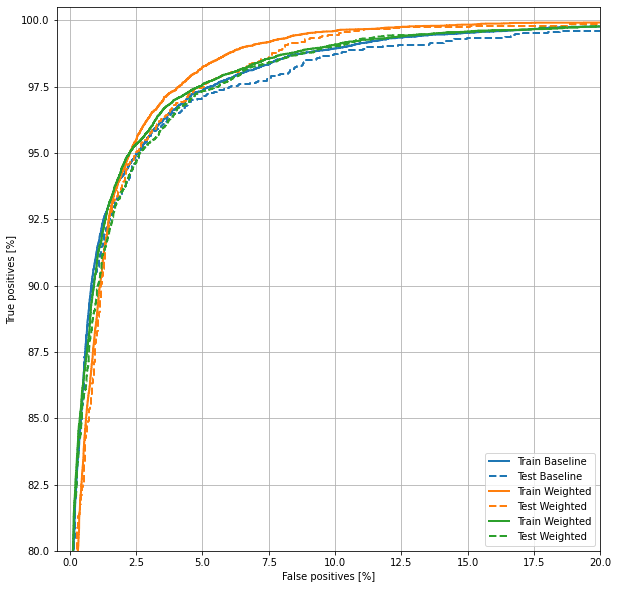

In [43]:
train_baseline_predictions = baseline_model.predict(X_train)
train_weighted_predictions = weighted_model.predict(X_train)
train_oversampled_predictions = oversampled_model.predict(resampled_X_train)

plot_roc("Train Baseline", y_train, train_baseline_predictions, color=colors[0])
plot_roc("Test Baseline", y_test, baseline_predictions, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train, train_weighted_predictions, color=colors[1])
plot_roc("Test Weighted", y_test, weighted_predictions, color=colors[1], linestyle='--')

plot_roc("Train Weighted", resampled_y_train, train_oversampled_predictions, color=colors[2])
plot_roc("Test Weighted", resampled_y_test, oversampled_predictions, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

## 2.2 Problem B (PoseNet)

...

### 2.2.1 PoseNet Cut Start model

...

### 2.2.2 PoseNet Cut Stop model

...

# 3. Conclusions and The Champion Model

...

# 4. Jira Updates (this part is kept intact from the first submission)

In this section, we're presenting the updates we've made to our workflow in Jira. We discussed these updates as a team after receiving feedback from last assignment about our previous setup. These changes consist of mainly four points:

1. **Simplify the board workflow into only 4 columns: To Do - In Progress - Review - Done**. Issues are assigned to team members that move their card(s) into the "In Progress" column. When work is finished, the card is moved into the "Review" column and either a pull request is created where the other team members approve the changes, or approval is seeked in another convenient way. 

2. **Integrate Jira with GitHub**. This integration makes it possible for us to track commits and associate them with Jira issues by referencing an issue in the git commit. 

3. **Implementing Story points**. We will start to work with Story points for sprint issues to get better at predicting how much work we can do each sprint and express an estimate of the effort each issue will need. 
We're planning to start with Story point estimation from next week's sprint, however during this week, we discussed if we should implemented some rules for Story point estimation. We agreed to use a planning poker exercise during our weekly sprint planning meeting, where we take an item from the sprint backlog, discuss it briefly, and each member formulate an estimation. By using the Fibonacci sequence, we can prevent estimates from being too close to one another.
We'll test using [Story Point Poker](https://storypoint.poker/) as the choice of tool. 

4. **Agreeing on a template for Card Descriptions in Jira**. This description includes a brief explanation of the task and finishes off with stating an acceptance criteria containing the team's benchmark for whether an issue is completed. 
We're planning to include these card descriptions as well from next sprint.